![](https://mp.weixin.qq.com/s/032Ywb8PCGlvCEYvt5qlkA)
[The hacker's guide to uncertainty estimates](https://erikbern.com/2018/10/08/the-hackers-guide-to-uncertainty-estimates.html)

In [1]:
import numpy
import random
import datetime

In [4]:
def generate_time_series(k=200,m=1000,sigma=100,n=50,
                        start_date=datetime.date(2017,7,1)):
    xs = numpy.linspace(0,1,n,endpoint = False)
    ys = [k*x + m + random.gauss(0,sigma) for x in xs]
    ts = [start_date + datetime.timedelta(x)*365 for x in xs]
    x_scale = numpy.linspace(-1,2,500)
    t_scale = [start_date + datetime.timedelta(x)*365 for x in x_scale]
    return xs,ys,ts,x_scale,t_scale

xs,ys,ts,x_scale,t_scale = generate_time_series()

Text(0, 0.5, 'Weight of elephant(kg)')

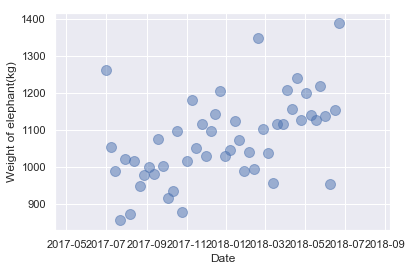

In [15]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

plt.scatter(ts,ys,alpha=0.5,s=100)
plt.xlabel('Date')
plt.ylabel('Weight of elephant(kg)') 

> 数据分布与不确定性

之前我一直搞不清“不确定性”的意思，但我认为搞清楚这一点非常重要。我们可以为多种不同的数据估算分布：

1. 数据本身。给定一定的时间范围（t ，t '），在这个时间间隔内大象体重的分布是什么？

2. 某些参数的不确定性。如参数k在线性关系y = k t + m里，或者某些估算器的不确定性，就像许多观测值的平均值一样。

3. 预测数值的不确定性。因此，如果我们预测日期为t（可能在未来）时大象的重量是y公斤，我们想知道数量y的不确定性。

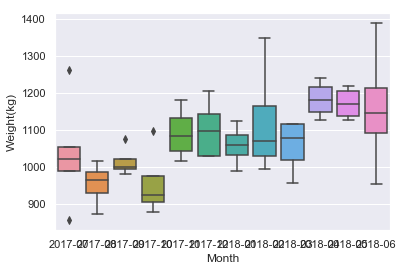

In [18]:
import pandas as pd
d = pd.DataFrame({'x':xs,'t':ts,'Weight(kg)':ys})
d['Month'] = d['t'].apply(lambda t: t.strftime('%Y-%m'))
sns.boxplot(data=d,x='Month',y='Weight(kg)')

`计算均值的不确定性 - 正态分布`

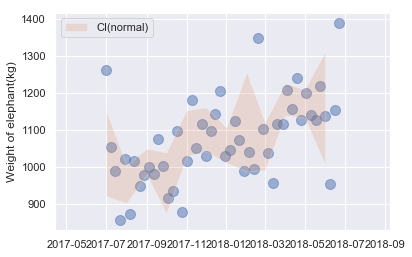

In [31]:
def plot_CI(obs_by_group):
    groups = list(sorted(obs_by_group.keys()))
    lo_bound = []
    hi_bound = []
    for group in groups:
        series = obs_by_group[group]
        mu,std,n = numpy.mean(series),numpy.std(series),len(series)
        lo_bound.append(mu - 1.96*std*n**-0.5)
        hi_bound.append(mu + 1.96*std*n**-0.5)
    plt.fill_between(groups,lo_bound,hi_bound,alpha=0.2,label='CI(normal)')

plt.scatter(ts,ys,alpha=0.5,s=100)
obs_by_month = {}
for month,y in zip(d['Month'],d['Weight(kg)']):
    obs_by_month.setdefault(month,[]).append(y)

plot_CI(obs_by_month)
plt.ylabel('Weight of elephant(kg)')
plt.legend()

`所有结果为0或1时的置信区间`

In [36]:
STATES = ['CA', 'NY', 'FL', 'TX', 'PA', 'IL', 'OH']
GROUPS = ['test', 'control']

def generate_binary_categorical(states=STATES, groups=GROUPS, k=400,
                                zs=[0, 0.2], z_std=0.1, b=-3, b_std=1):
    output = {}
    e_obs_per_state = numpy.random.exponential(k,size=len(states))
    state_bias = numpy.random.normal(b,b_std,size=len(states))
    for groups,z in zip(groups,zs):
        noise = numpy.random.normal(z,z_std,size=len(states))
        ps = 1 / (1 + numpy.exp(-(state_bias + noise)))
        ns =numpy.random.poisson(e_obs_per_state)
        ks = numpy.random.binomial(ns,ps)
        output[groups] = (ns,ks)
    return output

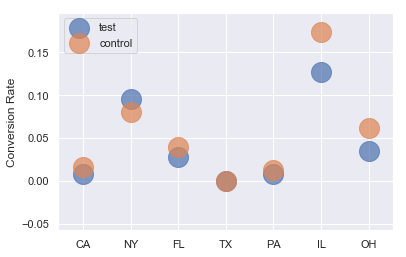

In [37]:
data = generate_binary_categorical()
for group, (ns,ks) in data.items():
    plt.scatter(STATES,ks/ns,label=group,alpha=0.7,s=400)
plt.ylabel("Conversion Rate")
plt.legend()

```python

n, k = 100, 3

scipy.stats.beta.ppf([0.025, 0.975], k, n-k)

array([0.00629335, 0.07107612])
```

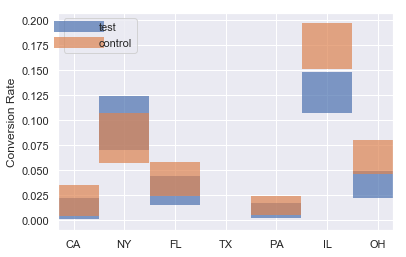

In [39]:
import scipy as scipy

for group,(ns,ks) in data.items():
    lo = scipy.stats.beta.ppf(0.025,ks,ns-ks)
    hi = scipy.stats.beta.ppf(0.975,ks,ns-ks)
    mean = ks/ns
    plt.errorbar(STATES,y=mean,yerr = [mean-lo,hi-mean],
                label=group,alpha=0.7,linewidth=0,elinewidth=50)
    
plt.ylabel('Conversion Rate')
plt.legend()

📝
`TBD`
Some example of A/B test from Book [Tableau商业分析从新手到高手](https://www.amazon.cn/dp/B07D55HVL3/ref=sr_1_2?ie=UTF8&qid=1544511736&sr=8-2&keywords=tableau)


In [1]:
import sys,os
os.getcwd()
os.chdir('C:\\Users\\randa\\Desktop\\JupyterNote\\Python\\PyPrac\\第10章')

In [2]:
import numpy as np
import pandas as pd

df_sales = pd.read_csv(r'sales.csv',encoding = 'utf-8')
df_test = pd.read_excel(r'test.xlsx',encoding='utf-8')
df = pd.merge(df_sales,df_test,on='Store_ID')
df.head()

,Store_ID,Week_Ending,Gross_Rev,Test_label,Group_label
0,S001,2010/1/2,59685.01,0,NaN
1,S001,2010/1/9,24946.82,0,NaN
2,S001,2010/1/16,26096.93,0,NaN
3,S001,2010/1/23,24475.04,0,NaN
4,S001,2010/1/30,29825.45,0,NaN


In [3]:
df['Week_Ending'] = pd.to_datetime(df['Week_Ending'])
df['Test_duration'] = np.where(df['Week_Ending']>'2011-10-08',1,0)

In [120]:
df[df['Test_label']==1].pivot_table(values='Gross_Rev',index='Store_ID',columns='Test_duration')

Test_duration,0,1
Store_ID,,
S027,73080.882581,87441.343478
S029,65101.063333,72233.871739
S035,55056.898065,59192.042174
S037,57839.269462,72874.807826
S044,62104.330108,72869.933913
S049,58574.878925,62091.186087
S063,52720.998817,57876.811304
S073,72112.395054,78429.596087
S082,60403.125376,69726.891739


In [122]:
# df[df['Test_label']==1].groupby(['Store_ID', 'Test_duration'])['Gross_Rev'].aggregate('mean').unstack()

In [9]:
plt_1 = df[df['Test_label']==1].pivot_table(values='Gross_Rev',index=['Store_ID','Test_duration'])
plt_1 = pd.DataFrame(plt_1)
plt_1 = plt_1.reset_index(level=['Store_ID','Test_duration'])
plt_1.head()

,Store_ID,Test_duration,Gross_Rev
0,S027,0,73080.882581
1,S027,1,87441.343478
2,S029,0,65101.063333
3,S029,1,72233.871739
4,S035,0,55056.898065


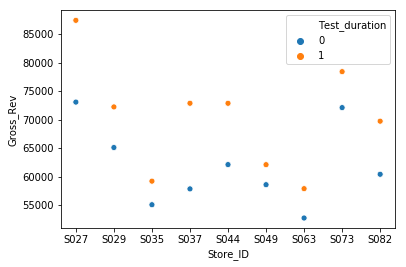

In [10]:
%matplotlib inline
# import matplotlib.pyplot as plt
import seaborn as sns; sns.set

sns.scatterplot(x='Store_ID',y='Gross_Rev',data=plt_1, hue='Test_duration')

> 首先观察测试店铺在测试期前后的销量情况。橙色是测试期间店铺的"周平均销售额"，蓝色为测试之前的一段时期店铺的"周平均销售额"。可以看到，所有测试店铺测试期间的销售额都比测试前有所提升，但我们还不能完全确定是由于采用新营销方法带来的销售提升，还是可**刚好**测试前后期间整体市场状况的改变带来了销售情况的变化。

In [7]:
plt_2 = df.pivot_table(index=['Store_ID','Test_duration'],values='Gross_Rev')
plt_2 = pd.DataFrame(plt_2)
plt_2 = plt_2.reset_index(level=['Test_duration'])
plt_2.head()

,Test_duration,Gross_Rev
Store_ID,,
S001,0,38823.417312
S001,1,38260.004783
S002,0,58632.199677
S002,1,63700.656957
S003,0,69467.889570


d:\python\python36-32\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


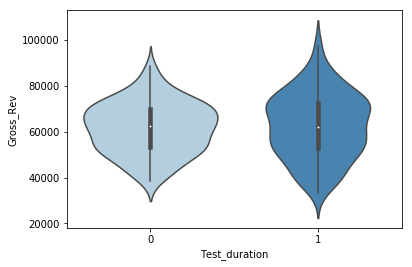

In [21]:
# sns.boxplot(x = 'Test_duration',y = 'Gross_Rev',data=plt_2)
# sns.swarmplot(x="Test_duration", y="Gross_Rev", data=plt_2, color=".3", linewidth=0)
sns.violinplot('Test_duration','Gross_Rev',data=plt_2, palette="Blues")

In [26]:
df[df.Group_label.notnull()].head()

,Store_ID,Week_Ending,Gross_Rev,Test_label,Group_label,Test_duration
1392,S013,2010-01-02,67975.60,0,S063,0
1393,S013,2010-01-09,34475.00,0,S063,0
1394,S013,2010-01-16,33501.27,0,S063,0
1395,S013,2010-01-23,35168.84,0,S063,0
1396,S013,2010-01-30,45957.85,0,S063,0


In [37]:
plt_3 = df[df.Group_label=='S027'].pivot_table(index=['Group_label','Store_ID','Week_Ending'],values='Gross_Rev')
plt_3 = pd.DataFrame(plt_3).reset_index(level=['Week_Ending','Group_label','Store_ID'])
plt_3.head()

,Group_label,Store_ID,Week_Ending,Gross_Rev
0,S027,S026,2010-01-02,29204.46
1,S027,S026,2010-01-09,44417.73
2,S027,S026,2010-01-16,63774.08
3,S027,S026,2010-01-23,67201.40
4,S027,S026,2010-01-30,65992.43


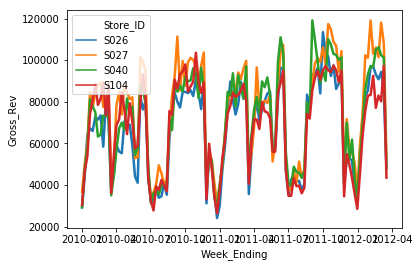

In [40]:
# sns.lineplot(data=plt_3,x='Week_Ending',y='Gross_Rev',hue='Store_ID')
sns.lineplot(data=plt_3,x='Week_Ending',y='Gross_Rev',hue='Store_ID',palette="tab10", linewidth=2.5)

In [86]:
plt_4 = df[df.Group_label=='S029'].pivot_table(index = ['Group_label','Store_ID'],columns = 'Test_duration',values = 'Gross_Rev')
plt_4 = pd.DataFrame(plt_4).reset_index(level=['Group_label','Store_ID'])
plt_4['Variance'] = (plt_4.loc[:,1] - plt_4.loc[:,0]) / plt_4.loc[:,0]
plt_4

Test_duration,Group_label,Store_ID,0,1,Variance
0,S029,S024,75436.367634,81373.583043,0.078705
1,S029,S029,65101.063333,72233.871739,0.109565
2,S029,S052,43437.957419,41541.221739,-0.043665
3,S029,S071,67105.499892,68502.206087,0.020814


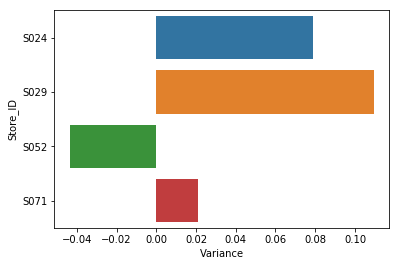

In [87]:
sns.barplot(x='Variance',y='Store_ID',data=plt_4)

📝 TBD Some example of ANOVA from Book [R in Action](http://www.ituring.com.cn/book/tupubarticle/9812)

In [110]:
#change kernel to R
library(xlsx)
df_1 <- read.table('C:/Users/randa/Desktop/JupyterNote/Python/PyPrac/第10章/sales.csv',header = T,sep = ',')
df_2 <- read.xlsx2('C:/Users/randa/Desktop/JupyterNote/Python/PyPrac/第10章/test.xlsx', 1)
# df_2[df_2$Group_label=="",3]  = NA #***#

In [111]:
df <- merge(df_1,df_2,by=c("Store_ID"),all.x = T,incomparables = NA)
head(df)

Store_ID,Week_Ending,Gross_Rev,Test_label,Group_label
S001,2010/1/2,59685.01,0,
S001,2012/2/4,34113.41,0,
S001,2010/7/17,48113.84,0,
S001,2011/7/23,40250.44,0,
S001,2012/1/28,28582.40,0,
S001,2010/7/10,49727.12,0,


In [112]:
df$Week_Ending <- as.Date(df$Week_Ending)
df$Test_duration <- ifelse(df$Week_Ending >'2011-10-08',1,0)

In [113]:
head(df)

Store_ID,Week_Ending,Gross_Rev,Test_label,Group_label,Test_duration
S001,2010-01-02,59685.01,0,,0
S001,2012-02-04,34113.41,0,,1
S001,2010-07-17,48113.84,0,,0
S001,2011-07-23,40250.44,0,,0
S001,2012-01-28,28582.40,0,,1
S001,2010-07-10,49727.12,0,,0


`含组间和组内因子的双因素方差分析`
> ***This A/B testing is kinda awkward***

In [114]:
library(reshape2) 
dcast(df[df$Group_label=='S027',], Group_label + Test_label + Store_ID ~ Test_duration, value.var = "Gross_Rev", mean)

Group_label,Test_label,Store_ID,0,1
S027,0,S026,65262.55,75239.75
S027,0,S040,69671.50,81946.04
S027,0,S104,67994.47,71252.16
S027,1,S027,73080.88,87441.34


`Reference`

- [Calculations for A/B Tests in R](https://www.r-bloggers.com/quick-significance-calculations-for-a-b-tests-in-r/)
- [Big Data Solutions: A/B t test](https://www.r-bloggers.com/big-data-solutions-ab-t-test/)
- [Tips for A/B Testing with R](https://www.r-bloggers.com/tips-for-ab-testing-with-r/)
- [Bayesian A/B Testing Made Easy](https://www.r-bloggers.com/bayesian-ab-testing-made-easy/)
- [New Course: A/B Testing in R](https://www.r-bloggers.com/new-course-a-b-testing-in-r/)
- [A/B testing advertisements with R](https://www.r-bloggers.com/ab-testing-advertisements-with-r/)